In [2]:
#Basic Implementation of GAN using tensorflow
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense
from keras.datasets import mnist
from keras.utils import to_categorical

11490434/11490434 [==============================] - 0s 0us/step


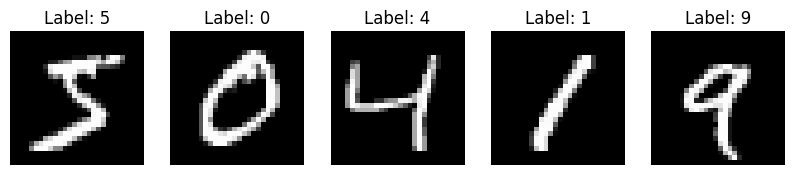

In [3]:
#Loading mnist Dataset
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()
#Printing some data from dataset
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(train_images[i],cmap='gray')
  plt.title(f"Label: {train_labels[i]}")
  plt.axis('off')

plt.show()

In [16]:
#Define Generator etwork
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256) #None is the Batch size

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape==(None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model
#Create generator
generator=make_generator_model()

In [18]:
#Define Discriminator Network
def make_discriminator_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2)) #Technique by reducing risk of overfitting

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2)) #Technique by reducing risk of overfitting

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model
#Create generator
generator=make_discriminator_model()

In [19]:
#Describe Loss Function
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Describe Discriminator Loss
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

#Describe generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [20]:
#Define Optimizer
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

#Define training step function
def train_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)

    gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    return gen_loss,disc_loss

In [21]:
#Define training loop with visualizations
def train(dataset,epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      gen_loss,disc_loss=train_step(image_batch)
      print(f'Epoch{epoch+1}/{epochs},Generator Loss:{gen_loss}, Discriminator Loss: {disc_loss}')

      #Generate and save images for visualization
      if epoch%10==0:
        generate_and_save_images(generator,epoch+1,seed)

#Function to generate and save images
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')

    plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
    plt.show()



In [ ]:
# Load and prepare the dataset (MNIST)
mnist = tf.keras.datasets.mnist
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1,1]

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define dimensionality of Random noise vector
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Train GAN
train(train_dataset, epochs=50)